# Bootstrapping Your Way to Uncertainty with Julia Language (Starring Zygote.jl)

We know from the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem) (Hornik 1989 [pdf](https://cognitivemedium.com/magic_paper/assets/Hornik.pdf) and Cybenko 1989 [pdf](https://cognitivemedium.com/magic_paper/assets/Cybenko.pdf)) that neural networks with at least one non-linear hidden layer should be able to represent arbitrary well-behaved functions, and indeed in the last decade we've seen that deep neural networks can handle a wide variety of input-output data mappings. However, neural networks don't intrinsicallyy tell us anything about their confidence: while output activation functions like softmax and sigmoid with a range from 0.0 to 1.0 might _seem_ like they naturally represent probabilities, they don't and treating them like they do can be dangerous. At least with regression models, where the output is some continuously valued scalar or vector of numbers, there isn't the same temptation to equate a prediction in the 0.90s as high-confidence inference. Inference for samples that are out-of-distribution with respect to the training data can be especially misleading. 

In this essay we'll look at a simple way to generate uncertainty estimates via training several different models on sub-samples of the training dataset. 

In [1]:
using Pkg
Pkg.activate("./bootstrap_demo")

using PyPlot
using Gtk
using ImageView
using Zygote


 Activating environment at `~/Desktop/.desktop/projects/SortaSota/bootstrap_demo/bootstrap_demo/Project.toml`
Gtk-Message: 14:00:26.440: Failed to load module "canberra-gtk-module"
Gtk-Message: 14:00:26.441: Failed to load module "canberra-gtk-module"


In [2]:
# These Base functions are explicitly imported so that they can be overloaded w/ multiple dispatch variants

import Base.-
import Base.*

## TL;DR Version

training model 1 of 13
loss at epoch 1 = 31.32917630393522
loss at epoch 501 = 16.442369078343074
loss at epoch 1001 = 4.71753576838056
loss at epoch 1501 = 2.0069688116244366
loss at epoch 2001 = 0.7428279453947777
loss at epoch 2501 = 0.4582904604471884
loss at epoch 3001 = 0.07809189388294417
loss at epoch 3501 = 0.08253251788465088
loss at epoch 4001 = 0.037618588318347954
loss at epoch 4501 = 0.021869061845727344
training model 2 of 13
loss at epoch 1 = 28.004842616272207
loss at epoch 501 = 5.998418454058686
loss at epoch 1001 = 2.0333614772980506
loss at epoch 1501 = 0.5185177827749713
loss at epoch 2001 = 0.2794271828080373
loss at epoch 2501 = 0.12825837030901663
loss at epoch 3001 = 0.06478655846249451
loss at epoch 3501 = 0.04283759084154265
loss at epoch 4001 = 0.04567714354897102
loss at epoch 4501 = 0.026756278245777296
training model 3 of 13
loss at epoch 1 = 29.48768191303768
loss at epoch 501 = 13.483887482004116
loss at epoch 1001 = 3.921278777747998
loss at epoch 150

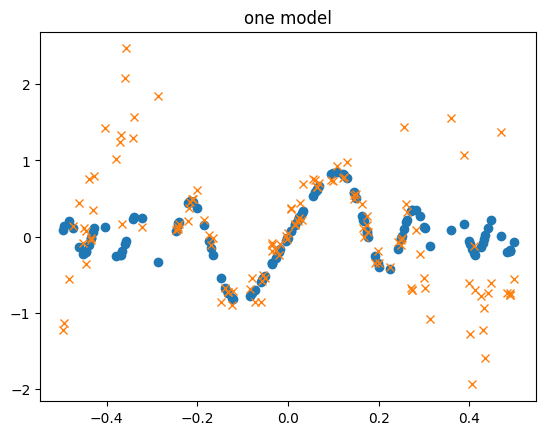

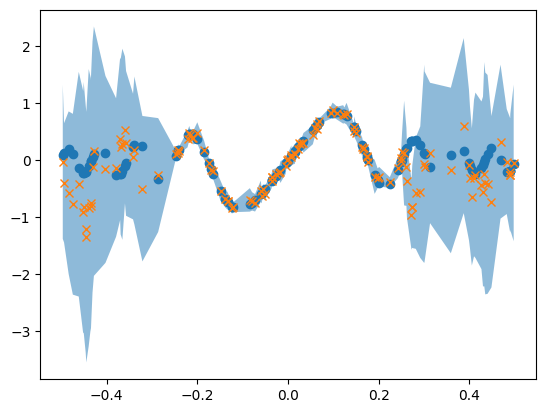

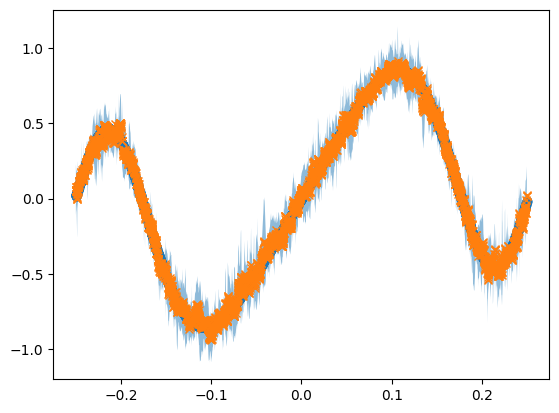

loss at epoch 4501 = 0.018248998194205304


In [3]:

# uncomment the line below to jump straight into the 
include("./src/bootstrap_demo.jl")

train_run()

## Target Functions


In [ ]:
# target functions
function my_sinc(number_samples::Int64=256, my_range::Array{Float64, 1}=[0.0, 1.0])
    
    x = (my_range[2] - my_range[1]) .* rand(number_samples, 1) .+ my_range[1]
    y = sin.(x .* 10) ./ x
    
    y = y ./ 10
    return x, y
    
end

function my_sinc2(number_samples::Int64=256, my_range::Array{Float64, 1}=[0.0, 1.0])
    
    x = (my_range[2] - my_range[1]) .* rand(number_samples, 1) .+ my_range[1] 
  
    y = sin.((x.* 10).^2) ./ x
     
    y = y ./ 10
    return x, y
    
end

# target functions

function parabola(number_samples::Int64=256, my_range::Array{Float64, 1}=[0.0, 1.0])
    
    x = (my_range[2] - my_range[1]) .* rand(number_samples, 1) .+ my_range[1] 
    y =  x.^2
    
    return x, y
    
end

function y_parabola(number_samples::Int64=256, my_range::Array{Float64, 1}=[0.0, 1.0])
    
    x = (my_range[2] - my_range[1]) .* rand(number_samples, 1) .+ my_range[1] 
    
    mode = (rand(number_samples) .> 0.5)
    println(mode)
    
    y =  (1.0 .* mode .+ -1.0 .* (1 .- mode)) .*  x.^(1. / 2.) 
    
    return x, y
    
end


    

## Functions and Structs Defining a Simple Multilayer Perceptron


In [ ]:
# structs for MLP

mutable struct MLPWeights #<: MultilayerPerceptron
   
    w_xh::Array{Float64, 2}
    w_hh::Array{Float64, 2}
    w_hy::Array{Float64, 2} 
    
end

mutable struct MLPWeightsAndBiases #<: MultilayerPerceptron
   
    w_xh::Array{Float64, 2}
    w_hh::Array{Float64, 2}
    w_hy::Array{Float64, 2}
    
    bias_xh::Array{Float64, 2}
    bias_hh::Array{Float64, 2}
    bias_hy::Array{Float64, 2}
    
end

# model initialization

function get_mlp(dim_x::Int64, dim_h::Int64, dim_y::Int64, bias::Bool=true)
   
    w_xh = randn(dim_x, dim_h)
    w_hh = randn(dim_h, dim_h)
    w_hy = randn(dim_h, dim_y)
    
    if bias
        
        bias_xh = randn(1, dim_h)
        bias_hh = randn(1, dim_h)
        bias_hy = randn(1, dim_y) 
        mlp = MLPWeightsAndBiases(w_xh, w_hh, w_hy, bias_xh, bias_hh, bias_hy)
    else
        
        mlp = MLPWeights(w_xh, w_hh, w_hy)
    end
    
    return mlp
end

# model functions (forward and gradient(forward))

function forward_mlp(x::Array{Float64,2}, mlp::MLPWeightsAndBiases)
    
    #act = (x -> tanh.(x))
    #act = (x -> (x .* (x .> 0.0) .+ 0.01 .* x))
    act = (x -> sin.(x.^2))
    
    h = act(x * mlp.w_xh .+ mlp.bias_xh)
    hh = act(h * mlp.w_hh .+ mlp.bias_hh)
    y = hh * mlp.w_hy .+ mlp.bias_hy
    
    return y
    
end

function forward_mlp(x::Array{Float64,2}, mlp::MLPWeights)
    
    act = (x -> sin.(x.^2))
    #(x -> (x .* (x .> 0.0) .+ 0.01 .* x)) 
    #(x -> tanh.(x))
    
    h = act(x * mlp.w_xh)
    hh = act(h * mlp.w_hh)
    y = hh * mlp.w_hy
    
    return y
    
end

function get_mlp_loss(x::Array{Float64,2}, y::Array{Float64,2}, mlp::MLPWeightsAndBiases)
    # get mse loss for y (target) and prediction (mlp(x))
    
    pred = forward_mlp(x, mlp)
    
    loss = sum((y .- pred).^2) / size(pred)[1]
    
    return loss
end

## Functions Facilitating Training

In [ ]:
function -(mlp::MLPWeightsAndBiases, grad_mlp::Tuple{Base.RefValue{Any}})
   
    new_mlp = mlp #copy(mlp)
    new_mlp.w_xh = mlp.w_xh - grad_mlp[1].x.w_xh
    new_mlp.w_hy = mlp.w_hy - grad_mlp[1].x.w_hy
    new_mlp.w_hh = mlp.w_hh - grad_mlp[1].x.w_hh
    
    new_mlp.bias_xh = mlp.bias_xh - grad_mlp[1].x.bias_xh
    new_mlp.bias_hh = mlp.bias_hh - grad_mlp[1].x.bias_xh
    new_mlp.bias_hy = mlp.bias_hy - grad_mlp[1].x.bias_hy
    
    return new_mlp
    
end


function *(lr, mlp::MLPWeightsAndBiases)
   
    new_mlp = mlp #copy(mlp)
    
    my_field_names = fieldnames(typeof(mlp))
    
    for my_field_name in my_field_names
       setproperty!(new_mlp, my_field_name, lr .* getproperty(mlp, my_field_name)) 
        
    end
    
    return new_mlp
    
end

function -(mlp::MLPWeightsAndBiases, grad_mlp::MLPWeightsAndBiases)
   
    new_mlp = mlp #copy(mlp)
    new_mlp.w_xh = mlp.w_xh - grad_mlp.w_xh
    new_mlp.w_hy = mlp.w_hy - grad_mlp.w_hy
    new_mlp.w_hh = mlp.w_hh - grad_mlp.w_hh
    
    new_mlp.bias_xh = mlp.bias_xh - grad_mlp.bias_xh
    new_mlp.bias_hh = mlp.bias_hh - grad_mlp.bias_hh
    new_mlp.bias_hy = mlp.bias_hy - grad_mlp.bias_hy
    
    return new_mlp
    
end

function get_mlp_gradient(x, y, mlp)
    
    my_field_names = fieldnames(typeof(mlp))
    
    grad = Zygote.gradient((mlp) -> get_mlp_loss(x, y, mlp), mlp)
    
    grad_mlp = typeof(mlp)(0.0 *copy(mlp.w_xh), 
        0.0 * copy(mlp.w_hy), 
        0.0 * copy(mlp.w_hh),
        0.0 *copy(mlp.bias_xh),
        0.0 *copy(mlp.bias_hh), 
        0.0 *copy(mlp.bias_hy))
    
    for jj in my_field_names
        
        #for i in fieldnames(A)
        #   setproperty!(a, i, 3)
        #en
        
        setproperty!(grad_mlp, jj, getproperty(grad[1].x, jj))
    
    end
    
    return grad_mlp
    
end

function train_mlp(x::Array{Float64,2}, y::Array{Float64,2}, 
        mlp::MLPWeightsAndBiases, epochs::Int64, lr::Float64=1e-3)

    disp_every = epochs / 10
    
    for epoch = 1:epochs
        
        if (epoch-1) % disp_every == 0
            loss = get_mlp_loss(x, y, mlp)
            println("loss at epoch $epoch = $loss") 
        end
        
        grad_mlp = get_mlp_gradient(x, y, mlp)
        #print(grad_mlp)
        mlp = mlp - lr * grad_mlp
        
    end
    
    return mlp
    
end

# train a bootstrap ensemble of mlps

function train_bootstrap(train_x::Array{Float64,2}, train_y::Array{Float64,2}, model_fn, num_straps::Int)

    models = []
    number_samples = 1024
    
    for kk = 1:num_straps
        
        sample_indices = rand(1:size(train_x)[1], (number_samples,1))
        sampled_x = train_x[sample_indices]
        sampled_y = train_y[sample_indices]
        
        mlp = model_fn(1, 64, 1)
        
        println("training model $kk of $num_straps")
        new_mlp = train_mlp(sampled_x, sampled_y, mlp, 5000, 1e-3)
        
        append!(models, [new_mlp])
        
    end
    
    return models
    
end


    
function ensemble_prediction(x::Array{Float64,2}, models::Array{Any,1})

    prediction = ""
    
    num_models = length(models)
    
    for model in models
       
        if prediction == ""
            prediction = forward_mlp(x, model)
        else
            prediction = cat(prediction, forward_mlp(x, model), dims=2)
        end
        
    end
    

    my_mean = (x -> sum(x, dims=2) / size(x)[2] )
    #
    std_dev = (x -> (sum( (my_mean(x) .- x).^2, dims=2) / size(x)[2]).^0.5)
        
    mean_pred = my_mean(prediction)
    standard_deviation = std_dev(prediction)
    
    return mean_pred[:,1], standard_deviation[:,1]
    
end

## Bootstrap Training

In [ ]:

x, y = my_sinc2(4096, [-.250, .250])

models = train_bootstrap(x, y, get_mlp, 13)

val_x, val_y = my_sinc2(128, [-.5, .5])

val_pred = forward_mlp(val_x, models[1])

PyPlot.figure()
PyPlot.plot(val_x[:,1], val_y[:,1], "o")

PyPlot.plot(val_x[:,1], val_pred[:,1], "x")
PyPlot.title("one model")
PyPlot.show()

val_pred, val_std = ensemble_prediction(val_x, models)
train_pred, train_std = ensemble_prediction(x, models)

sort_indices = sortperm(val_x[:,1])

val_x = val_x[sort_indices]
val_y = val_y[sort_indices]
val_pred = val_pred[sort_indices]

val_std = val_std[sort_indices]

sort_indices = sortperm(x[:,1])
x = x[sort_indices]

y = y[sort_indices]
train_pred = train_pred[sort_indices]
train_std = train_std[sort_indices]

PyPlot.figure()
PyPlot.plot(val_x[:,1], val_y[:,1], "o")

PyPlot.plot(val_x[:,1], val_pred[:,1], "x")
PyPlot.fill_between(val_x[:,1], val_pred.-val_std, val_pred.+val_std, alpha=0.5)
PyPlot.show()

PyPlot.figure()
PyPlot.plot(x[:,1], y[:,1], "o")

PyPlot.plot(x[:,1], train_pred[:,1], "x")
PyPlot.fill_between(x[:,1], train_pred .- train_std, train_pred .+ train_std, alpha=0.5)
PyPlot.show()

